In [1]:
cd drive/MyDrive/NN\ Assignment

/content/drive/MyDrive/NN Assignment


In [2]:
!pwd

/content/drive/MyDrive/NN Assignment


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import tensorflow as tf
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler

tf.logging.set_verbosity(tf.logging.INFO)
sess = tf.InteractiveSession()

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
#all features
print('Shape of the train data with all features:', train.shape)
train = train.select_dtypes(exclude=['object'])
print("")

#numerical features
print('Shape of the train data with numerical features:', train.shape)

train.drop('Id',axis = 1, inplace = True)
train.fillna(0,inplace=True)
train.columns

Shape of the train data with all features: (1460, 81)

Shape of the train data with numerical features: (1460, 38)


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [7]:
test = test.select_dtypes(exclude=['object'])
ID = test.Id
test.fillna(0,inplace=True)
test.drop('Id',axis = 1, inplace = True)

81 cols, 38 numerical cols, 1460 rows

Detection of Outliers - Isolation Forest:
we can not only detect anomalies faster but we also require less memory compared to other algorithms.

How it works:
The Isolation Forest algorithm is based on the principle that anomalies are observations that are few and different, which should make them easier to identify. Isolation Forest uses an ensemble of Isolation Trees for the given data points to isolate anomalies.

It isolates anomalies in the data points instead of profiling normal data points. As anomalies data points mostly have a lot shorter tree paths than the normal data points, trees in the isolation forest does not need to have a large depth so a smaller max_depth can be used resulting in low memory requirement.

In [8]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 139
Number of rows without outliers: 1321


Preprocessing - MinMaxScaler
Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.



In [9]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('SalePrice') #because Sale Price is our Target Variable

mat_train = np.matrix(train)
mat_test  = np.matrix(test)
mat_new = np.matrix(train.drop('SalePrice',axis = 1)) 
mat_y = np.array(train.SalePrice).reshape((1321,1)) #not considering outliers

prepro_y = MinMaxScaler()
#prepro_y = RobustScaler()
prepro_y.fit(mat_y)
#prepro_y.fit(mat_y.reshape(-1, 1))

prepro = MinMaxScaler()
#prepro = RobustScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
#prepro_test = RobustScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.235294,0.207668,0.062802,0.625,0.428571,0.953488,0.883333,0.12250,0.416274,0.0,0.070721,0.266999,0.200384,0.530106,0.0,0.461538,0.333333,0.0,0.666667,0.5,0.500000,0.0,0.555556,0.000000,0.996517,0.50,0.394245,0.000000,0.167582,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,0.403057
1,0.000000,0.255591,0.072904,0.500,0.857143,0.744186,0.433333,0.00000,0.576651,0.0,0.133899,0.393637,0.395014,0.000000,0.0,0.298984,0.000000,0.5,0.666667,0.0,0.500000,0.0,0.333333,0.333333,0.983085,0.50,0.330935,0.404891,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,0.340220
2,0.235294,0.217252,0.087396,0.625,0.428571,0.937984,0.866667,0.10125,0.286557,0.0,0.204620,0.286962,0.231064,0.537554,0.0,0.489115,0.333333,0.0,0.666667,0.5,0.500000,0.0,0.333333,0.333333,0.995522,0.50,0.437410,0.000000,0.115385,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,0.437966
3,0.294118,0.191693,0.072464,0.625,0.428571,0.271318,0.333333,0.00000,0.127358,0.0,0.254597,0.235808,0.250719,0.469274,0.0,0.464078,0.333333,0.0,0.333333,0.0,0.500000,0.0,0.444444,0.333333,0.994030,0.75,0.461871,0.000000,0.096154,0.824242,0.0,0.0,0.0,0.0,0.090909,0.00,0.243639
4,0.235294,0.268371,0.113835,0.750,0.428571,0.930233,0.833333,0.21875,0.386203,0.0,0.231023,0.357143,0.338926,0.653631,0.0,0.638607,0.333333,0.0,0.666667,0.5,0.666667,0.0,0.666667,0.333333,0.995025,0.75,0.601439,0.260870,0.230769,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,0.499638


In [10]:
# List of features
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "SalePrice"

# Columns for tensorflow
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.SalePrice

# Train and Test 
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_set.head()

# Training for submission
training_sub = training_set[col_train]

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [11]:
#repeating the process with test set
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)
testing_set.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
727,0.352941,0.239617,0.074221,0.375,0.428571,0.674419,0.283333,0.00,0.235849,0.325645,0.047148,0.305677,0.259827,0.000000,0.0,0.196662,0.0,0.0,0.666667,0.0,0.500000,0.0,0.333333,0.000000,0.978607,0.25,0.276259,0.092391,0.000000,0.0,0.0,0.0,0.0,0.0,0.818182,0.00,0.233166
479,0.000000,0.000000,0.100440,0.250,0.428571,0.713178,0.366667,0.00,0.353774,0.000000,0.124470,0.269495,0.204219,0.000000,0.0,0.154572,0.0,0.0,0.333333,0.0,0.500000,0.0,0.222222,0.000000,0.985075,0.50,0.414388,0.293478,0.000000,0.0,0.0,0.0,0.0,0.0,0.272727,0.50,0.176730
240,0.058824,0.226837,0.049188,0.375,0.571429,0.465116,0.083333,0.00,0.237618,0.084803,0.099953,0.230817,0.162991,0.000000,0.0,0.123367,0.0,0.0,0.333333,0.0,0.333333,0.0,0.111111,0.333333,0.978109,0.25,0.664748,0.000000,0.068681,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,0.198257
422,0.294118,0.252396,0.071850,0.375,0.714286,0.480620,0.750000,0.14,0.227594,0.000000,0.161245,0.227074,0.215724,0.469274,0.0,0.437591,0.0,0.0,0.333333,0.5,0.500000,0.0,0.444444,0.666667,0.966169,0.25,0.224460,0.228261,0.000000,0.0,0.0,0.0,0.0,0.0,0.454545,0.25,0.258766
49,0.352941,0.191693,0.051243,0.375,0.428571,0.581395,0.083333,0.00,0.226415,0.000000,0.000000,0.119775,0.441994,0.000000,0.0,0.334543,0.0,0.0,0.333333,0.0,0.500000,0.0,0.333333,0.333333,0.976119,0.50,0.411511,0.000000,0.137363,0.0,0.0,0.0,0.0,0.0,0.090909,0.25,0.220366


In [12]:
# Model
tf.logging.set_verbosity(tf.logging.ERROR)
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols,activation_fn=tf.nn.relu,hidden_units=[250, 150, 100, 50, 10],optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 ))

In [13]:
# Reset the index of training
training_set.reset_index(drop = True, inplace =True)

In [14]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in FEATURES}
        
        return feature_cols

In [19]:
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2500)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x7f057aca7b10>, 'hidden_units': [250, 150, 100, 50, 10], 'feature_columns': (_RealValuedColumn(column_name='MSSubClass', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotFrontage', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='LotArea', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallQual', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='OverallCond', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearBuilt', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='YearRemodAdd', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(co

In [20]:
#evaluation
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 0.002830


In [21]:
# Predictions
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(predictions).reshape(436,1)),columns = ['Prediction'])

#Actual 
reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns = COLUMNS).SalePrice

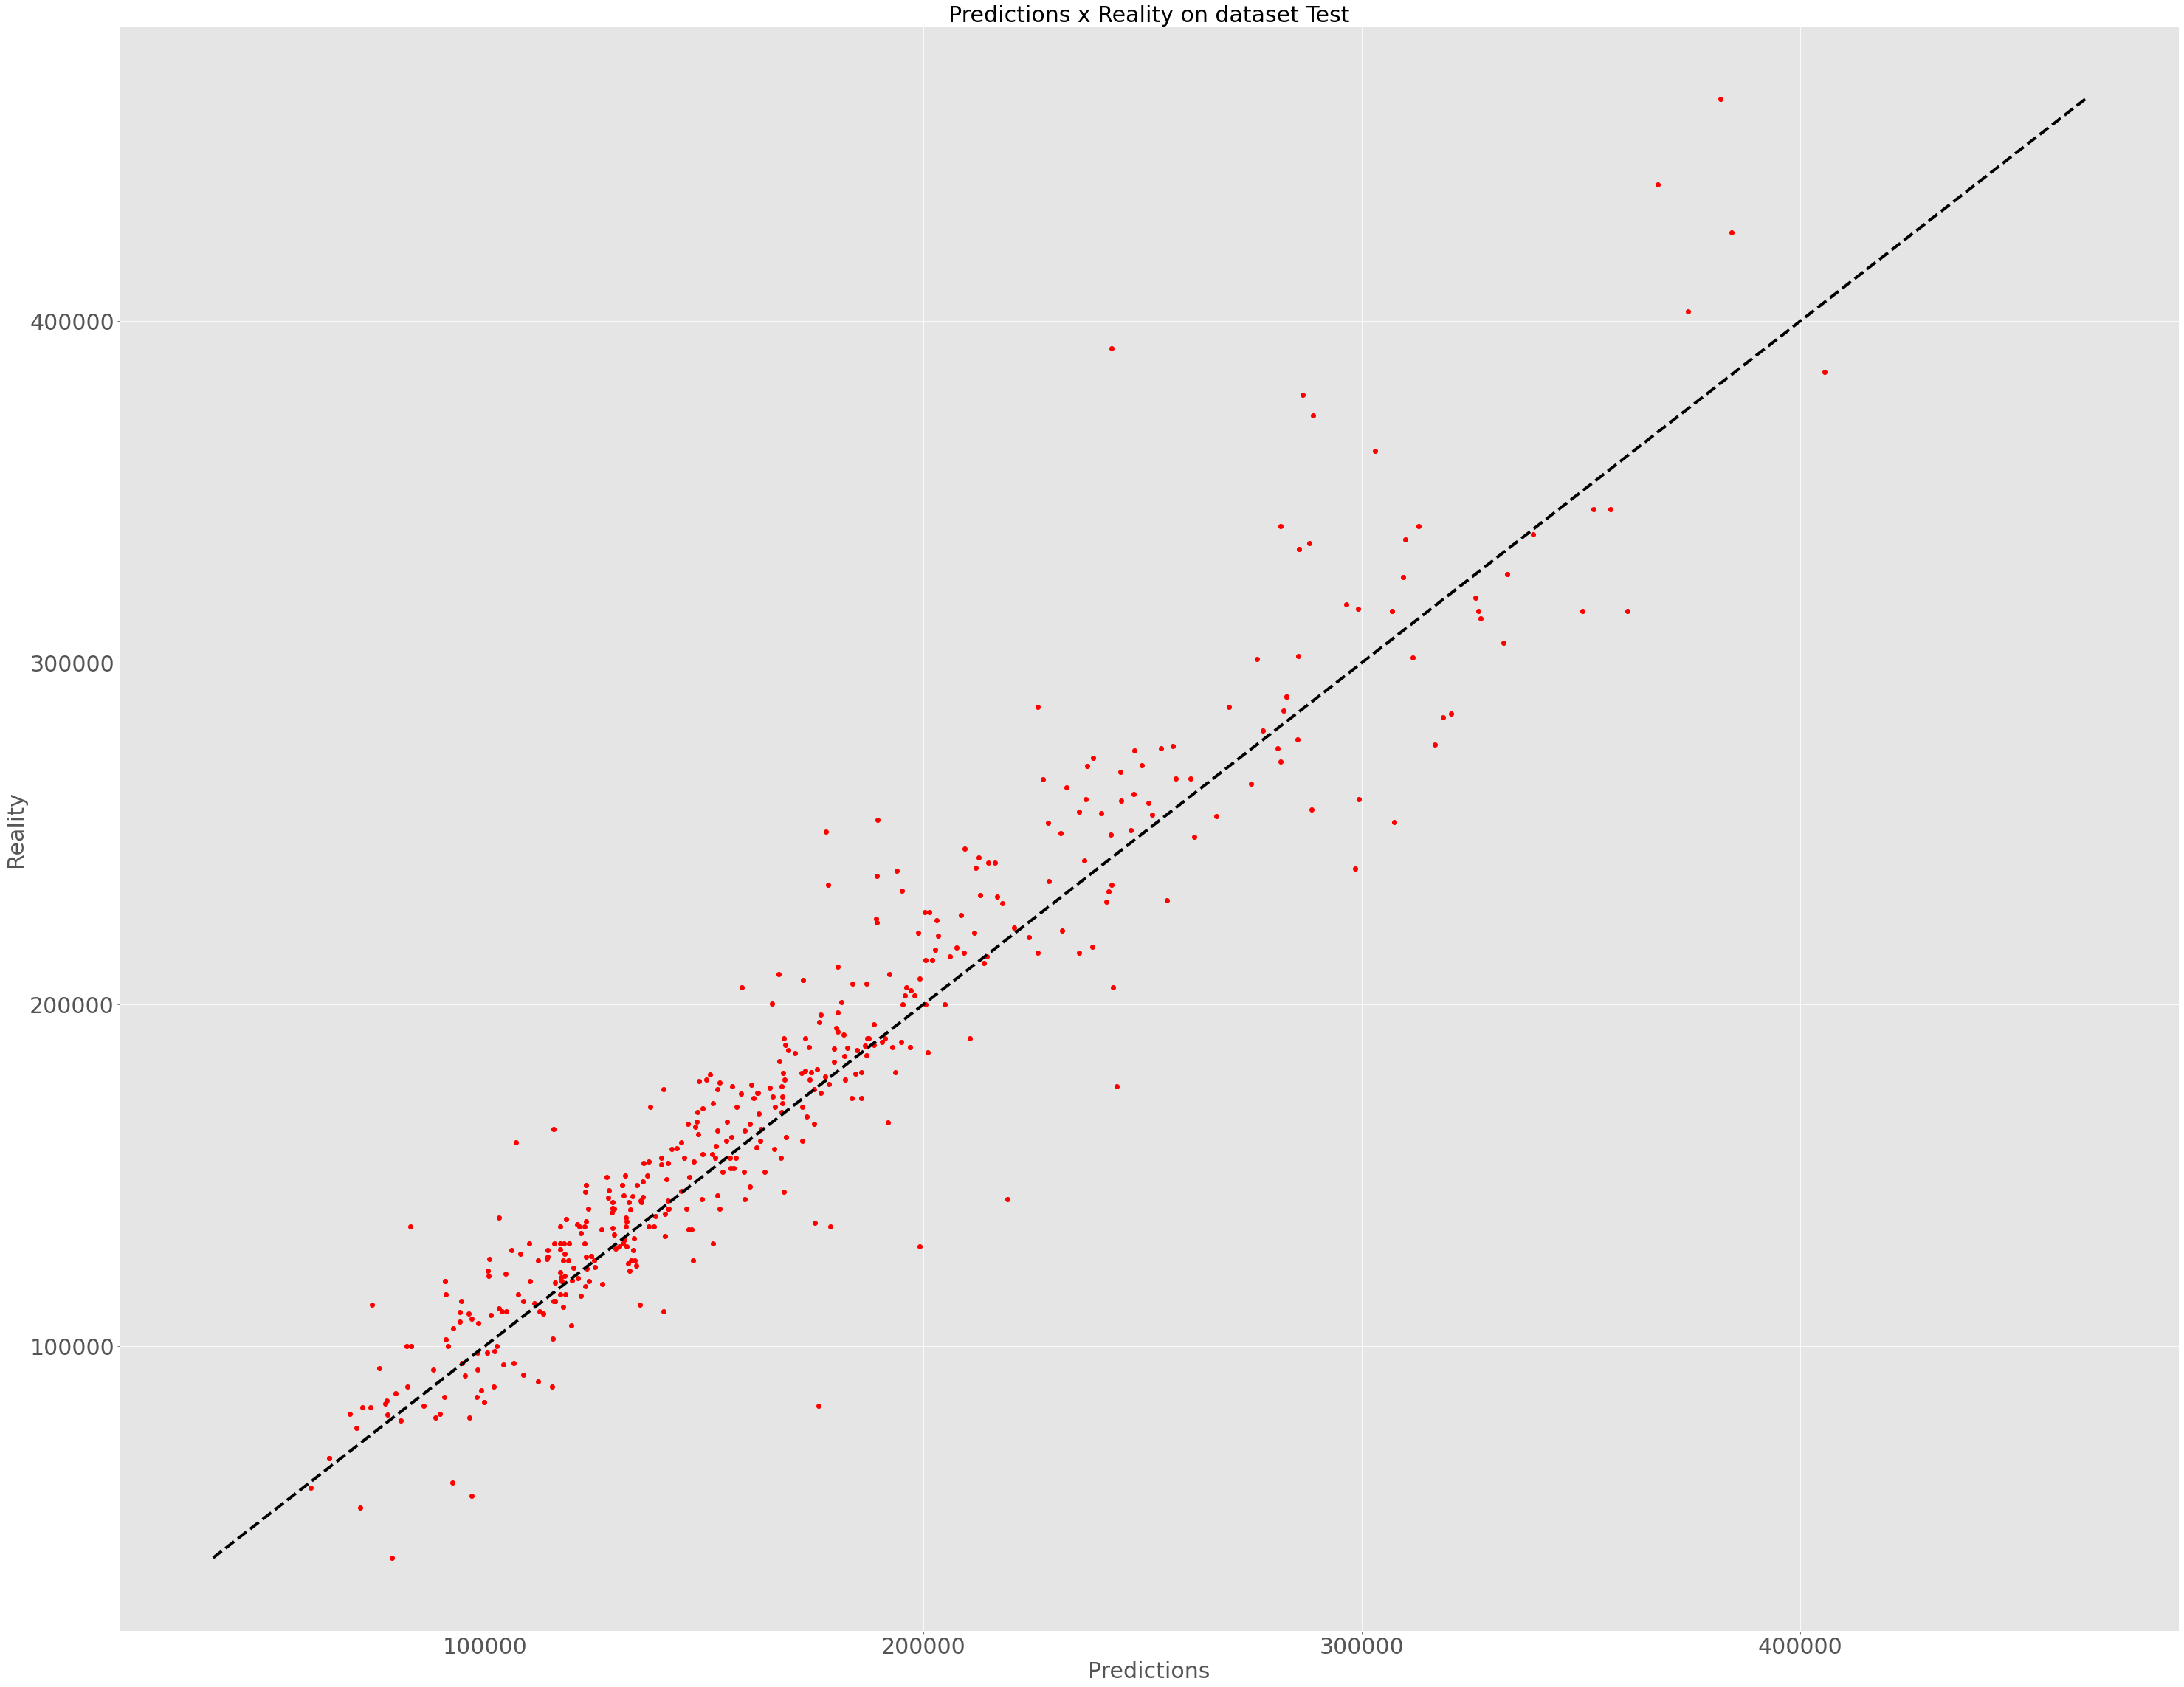

In [22]:
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

fig, ax = plt.subplots(figsize=(50, 40))

plt.style.use('ggplot')
plt.plot(predictions.values, reality.values, 'ro')
plt.xlabel('Predictions', fontsize = 30)
plt.ylabel('Reality', fontsize = 30)
plt.title('Predictions x Reality on dataset Test', fontsize = 30)
ax.plot([reality.min(), reality.max()], [reality.min(), reality.max()], 'k--', lw=4)
plt.show()